# BioData Basel Open Targets Datathon
**Matthew R. Nelson**

**November 19, 2018**

## Introduction
There has been exponential growth in the genetic and genomic data being produced to yield new insights into biology, and particularly with the intent to understand the role of genes and proteins and pathways in disease.  Despite this, selecting protein targets for drug discovery still seems more of an art, guided by intuition and influenced by cognitive biases, than a reproducible science.  Open Targets was established to bring the data and science together in a pre-competitive environment to help foster better early discovery decision making.  In this dual session, we will introduce and engage the participants to the science of target selection.  In this datathon, you will be introduced to the evidence types Open Targets is currently using to established relationships between genes and disease to aid in selecting and validating prospective drug targets.

You will be introduced to several genomic and gene-disease data sources.  You are tasked with exploring methods for using these data for predicting drug development success.  Insights and feedback from among the participants will be collated and shared, and may be used in future development of the Open Targets platform.  

Prior to the datathon, you are encouraged to download the data files, view the example analysis notebooks available in R and Python, and review the data documentation.  A brief summary will be provided during the introductory session and researchers from Open Targets and GSK will be on hand to answer any questions you may have.  

At the datathon, you will be divided into small groups where you can work individually or jointly to explore these data, their relationships to development outcomes, and methods of modeling them to predict outcomes.  At the end of the datathon, groups will be invited to share their experiences and discuss potential next steps.  You are welcome to use whatever analysis tools you prefer for this analysis exercise.




## Data Import

The three primary datathon files are summarized below.  You can find a more complete description of each data file and the variables within them at the datathon Wiki site.

**Note about neoplasm versus non-neoplasm indications:** Because the genomic evidence that may be important for neoplasms may be very different than for non-neoplasms, we restrict this summary of the data to non-neoplasm data only.

In [133]:
## Load packages to use
library(ggplot2) # Plotting functions
library(tidyr) # Use gather() for reformatting to long-skinny
library(dplyr) # Using chaining (%>%) and several dplyr verbs

### Pharmaprojects data
The first data file, Pprojects_drugs_TTlabel.csv, is derived from Informa Pharmaprojects, a commercial database tracking the development of over 68,000 drugs over the past several decades.  Researchers at GSK have carefully processed and curated this database to create a summary of all target-indication pairs (T-I) that have entered clinical development, tracking the furthest stage of development achieved.  A T-I is considered successful if any drug annotated to act through the selected target was approved for the accompanying indication.  Further details are available on the See [the datathon Wiki site](https://github.com/opentargets/BioDataEU_2018/wiki/Datasets-Index) for details.  The objective of this datathon is to identify the genomic factors that predict successful T-Is (for example, see the related paper by Nelson et al. 2015).  Informa has permitted us to make these data freely available to the datathon participants during the course of this datathon.  They must be permanently deleted after the datathon work is completed, as agreed in the survey.  We have identified 80%/20% of T-Is as a training set and test set.  We encourage any participants interested in exploring predictive models to use them as such.

In [134]:
pp.data = read.csv("Pprojects_drugs_TTlabel.csv",
                  na.strings = c("NA", ""), header = TRUE) %>%
  filter(DiseaseType %in% "Non-Neoplasm") %>% 
  rename(key = target_indication)

In [135]:
summary(pp.data)

                           key              ensembl_gene_id       disease_id  
 ENSG00000000971-EFO_0000253 :   1   ENSG00000113580:  97   EFO_0000685: 171  
 ENSG00000001626-EFO_0000555 :   1   ENSG00000073756:  85   EFO_0000676: 158  
 ENSG00000001626-HP_0002014  :   1   ENSG00000095303:  79   EFO_0000198: 138  
 ENSG00000001626-Orphanet_586:   1   ENSG00000065989:  63   EFO_0003843: 128  
 ENSG00000001630-EFO_0003914 :   1   ENSG00000184588:  61   EFO_0000270: 126  
 ENSG00000003436-EFO_0001420 :   1   ENSG00000105650:  59   EFO_0000249: 113  
 (Other)                     :7874   (Other)        :7436   (Other)    :7046  
   entrez_id            MeSH_ID           DiseaseType  
 Min.   :        2   D001172: 171   Neoplasm    :   0  
 1st Qu.:     1815   D011565: 158   Non-Neoplasm:7880  
 Median :     3596   D009190: 138                      
 Mean   :    35198   D001249: 126                      
 3rd Qu.:     5743   D000544: 113                      
 Max.   :100133941   D003924: 11

### Open Targets Evidence Scores

The second dataset includes the evidence scores that are available through the [Open Targets Portal](http://www.targetvalidation.org/).  See [the datathon Wiki pages](https://github.com/opentargets/BioDataEU_2018/wiki/Datasets-Index) for details.

The data file provided includes target evidence scores for all target-indication combinations available in the Open Targets database (over 2.4 million).  As the focus of this exercise is to predict clinical success of target-indication pairs, I have imported the large data file and saved the overlap with Pharmaprojects as a separate, much smaller data set.

In [136]:
## Create a small dataset matched to pp.data
#ot.data.all = read.csv("gene_disease_associations_with_expression.csv.gz",
#                       na.strings = c("NA", ""), header = TRUE)
# dim(ot.data.all)
# 2405593 38
write.table(subset(ot.data.all, target_indication %in% pp.data$key),
            file = "PP_gene_disease_associations.csv", 
            sep = ",", na = "NA", 
            row.names = FALSE)

In [137]:
names(ot.data.all)

[1] "target_indication"   "entrez_id"           "ensembl_gene_id"    
 [4] "symbol"              "disease_id"          "disease_label"      
 [7] "therapeutic_area"    "is_direct"           "overall_score"      
[10] "genetic_association" "somatic_mutation"    "known_drug"         
[13] "rna_expression"      "affected_pathway"    "animal_model"       
[16] "literature"          "expression_atlas"    "uniprot"            
[19] "gwas_catalog"        "phewas_catalog"      "eva"                
[22] "uniprot_literature"  "genomics_england"    "gene2phenotype"     
[25] "reactome"            "slapenrich"          "progeny"            
[28] "phenodigm"           "cancer_gene_census"  "eva_somatic"        
[31] "uniprot_somatic"     "intogen"             "chembl"             
[34] "europepmc"           "tissue_label"        "source"             
[37] "max_fold_change"     "expression_score"

Now we can simply import the smaller dataset to make re-running this notebook much simpler.

In [138]:
ot.data <- read.csv("PP_gene_disease_associations.csv", 
                    na.strings = c("NA", ""), header = TRUE) %>% 
            rename(key = target_indication)
dim(ot.data)
summary(ot.data)

[1] 5121   38

                             key         entrez_id        
 ENSG00000000971-EFO_0000253   :   1   Min.   :        2  
 ENSG00000001626-EFO_0000555   :   1   1st Qu.:     1815  
 ENSG00000001626-HP_0002014    :   1   Median :     3587  
 ENSG00000001626-Orphanet_586  :   1   Mean   :    29466  
 ENSG00000003436-Orphanet_903  :   1   3rd Qu.:     5743  
 ENSG00000003436-Orphanet_98878:   1   Max.   :100133941  
 (Other)                       :5115                      
        ensembl_gene_id     symbol           disease_id  
 ENSG00000073756:  72   PTGS2  :  72   EFO_0000685: 150  
 ENSG00000113580:  68   NR3C1  :  68   EFO_0000676: 135  
 ENSG00000095303:  57   PTGS1  :  57   EFO_0000270: 116  
 ENSG00000232810:  51   TNF    :  51   EFO_0003843: 115  
 ENSG00000149295:  46   DRD2   :  46   EFO_0000198: 103  
 ENSG00000102468:  35   HTR1A  :  35   EFO_0000249:  98  
 (Other)        :4792   (Other):4792   (Other)    :4404  
                  disease_label                               th

In [139]:
subset(ot.data, key %in% "ENSG00000105650-MP_0001845")

key,entrez_id,ensembl_gene_id,symbol,disease_id,disease_label,therapeutic_area,is_direct,overall_score,genetic_association,...,cancer_gene_census,eva_somatic,uniprot_somatic,intogen,chembl,europepmc,tissue_label,source,max_fold_change,expression_score
ENSG00000105650-MP_0001845,5143,ENSG00000105650,PDE4C,MP_0001845,inflammation,phenotype,True,0.203582,0,...,0,0,0,0,0.2,0.014328,Unspecified,Unspecified,0,0


### Additional Gene Characteristics of Interest

In addition to the current Open Targets evidence scores, we include a number of other genomic characteristics that may be insightful in differentiating between effective and ineffective mechanisms.  See [the datathon Wiki pages](https://github.com/opentargets/BioDataEU_2018/wiki/Datasets-Index) for details.

In [140]:
#gene.data.all <- read.csv("gene_info_qtq.csv", 
#                          na.strings = c("NA", ""), header = TRUE)
#write.table(subset(gene.data.all, entrez_id %in% pp.data$entrez_id),
#            file = "PP_gene_info_qtq.csv", sep = ",", na = "NA", 
#            row.names = FALSE)

In [141]:
gene.data <- read.csv("PP_gene_info_qtq.csv", 
                    na.strings = c("NA", ""), header = TRUE) %>%
  select(-X, -hgnc_id, -ensembl_gene_id, -uniprot_id)
dim(gene.data)
length(unique(gene.data$entrez_id))
summary(gene.data)


[1] 40518    16

[1] 1108

     symbol        entrez_id                              locus_type   
 JAK2   :  248   Min.   :        2   endogenous retrovirus     :    7  
 TGFB1  :  231   1st Qu.:     1815   gene with protein product :40486  
 CTNNB1 :  218   Median :     3757   immunoglobulin gene       :   17  
 AKT1   :  179   Mean   :    96704   RNA, micro                :    5  
 SIRT1  :  177   3rd Qu.:     6387   RNA, misc                 :    1  
 (Other):39464   Max.   :100133941   T-cell receptor gene      :    1  
 NA's   :    1                       T-cell receptor pseudogene:    1  
              locus_group           go_id      
 non-coding RNA     :    6   GO:0005886:  842  
 other              :   25   GO:0005515:  775  
 protein-coding gene:40486   GO:0005829:  456  
 pseudogene         :    1   GO:0005576:  390  
                             GO:0005887:  358  
                             (Other)   :37686  
                             NA's      :   11  
                                  go_lab

Most of the descriptors in this data set have a single value for each gene:

In [142]:
apply(gene.data, 2, function(x) length(unique(paste(gene.data$symbol, x))))

symbol               entrez_id              locus_type 
                   1108                    1108                    1108 
            locus_group                   go_id                go_label 
                   1108                   37167                   37167 
          evidence_type          reported_count           protein_class 
                   6620                    3886                    1124 
           target_class           topology_type         target_location 
                   1108                    1108                    1108 
               ExAC_LoF  pc_mouse_gene_identity GTEX_median_all_tissues 
                   1108                    1108                    1108 
            description 
                   1108

In this analysis, I'm not doing anything sophisticated with the various GO terms.  To simplify this, I create an analysis version by reducing this data set to the first occurance of each each gene.

In [143]:
ugene.data <- gene.data %>%
    subset(!duplicated(symbol))

### Merge all data sets into single data frame for analysis

In [144]:
all.data <- pp.data %>%
    filter(Clinical.Label_PP %in% c("Clinical Failure", 
                                    "Succeeded")) %>%
    inner_join(ot.data) %>%
    left_join(ugene.data) %>%
    mutate(clinical.outcome = 
           droplevels(recode_factor(Clinical.Label_PP, 
                                    `Clinical Failure` = "Failure", 
                                    `Succeeded` = "Success")))
dim(all.data)
summary(all.data)

Joining, by = c("key", "ensembl_gene_id", "disease_id", "entrez_id")
Warning message:
"Column `key` joining factors with different levels, coercing to character vector"Warning message:
"Column `ensembl_gene_id` joining factors with different levels, coercing to character vector"Warning message:
"Column `disease_id` joining factors with different levels, coercing to character vector"Joining, by = c("entrez_id", "symbol")
Warning message:
"Column `symbol` joining factors with different levels, coercing to character vector"

[1] 4064   61

     key            ensembl_gene_id     disease_id          entrez_id        
 Length:4064        Length:4064        Length:4064        Min.   :        2  
 Class :character   Class :character   Class :character   1st Qu.:     1813  
 Mode  :character   Mode  :character   Mode  :character   Median :     3557  
                                                          Mean   :    33352  
                                                          3rd Qu.:     5742  
                                                          Max.   :100133941  
                                                                             
    MeSH_ID           DiseaseType              Clinical.Label_PP
 D001172: 130   Neoplasm    :   0   Clinical Failure    :2772   
 D011565: 114   Non-Neoplasm:4064   In Progress Clinical:   0   
 D001249: 104                       Succeeded           :1292   
 D000544:  73                                                   
 D003924:  73                                      

In [145]:
write.csv(all.data, "all_data.csv", na = "")

## Data Exploration
In this section, we perform some basic exploratory data visualizations and summaries to understand the score and evidence distributions and their relationships with clinical success.

### Quantitative Open Targets scores

Put data into a long format to permit trellised ggplots

In [146]:
id.vars = c('key', 'symbol', 'disease_label')
outcome.vars = c('Clinical.Label_PP', 'Furthest.Phase', 
                 'Therapeutic.Direction', 'clinical.outcome')
ot.scores = c('overall_score', 'genetic_association',
              'known_drug', 'rna_expression', 'expression_score', 
           'affected_pathway', 'animal_model', 'literature')
otsrc.scores = c('expression_atlas', 'uniprot', 'gwas_catalog', 
                 'phewas_catalog',
                 'eva', 'uniprot_literature', 'genomics_england', 
                 'gene2phenotype',
                 'reactome', 'slapenrich', 'phenodigm', 'europepmc')
gene.qvars = c('pc_mouse_gene_identity', 'GTEX_median_all_tissues')
gene.cvars = c('protein_class', 'target_class', 'topology_type', 
               'target_location', 'ExAC_LoF')

In [147]:
all.long = gather(all.data[, c(id.vars, outcome.vars, ot.scores, 
                               otsrc.scores, gene.qvars)], 
                  datasource, score, 
                  overall_score:GTEX_median_all_tissues, 
                  factor_key = TRUE)
ot.long = gather(all.data[, c(id.vars, outcome.vars, ot.scores, 
                              otsrc.scores)], 
                 datasource, score, 
                 overall_score:europepmc, 
                 factor_key = TRUE)

In [148]:
dim(ot.long)
summary(ot.long)

[1] 81280     9

     key               symbol                            disease_label  
 Length:81280       Length:81280       rheumatoid arthritis     : 2600  
 Class :character   Class :character   psoriasis                : 2280  
 Mode  :character   Mode  :character   asthma                   : 2080  
                                       pain                     : 2040  
                                       Alzheimers disease       : 1460  
                                       type II diabetes mellitus: 1460  
                                       (Other)                  :69360  
            Clinical.Label_PP            Furthest.Phase 
 Clinical Failure    :55440   Clinical Phase I  :15540  
 In Progress Clinical:    0   Clinical Phase II :30120  
 Succeeded           :25840   Clinical Phase III: 9100  
                              Succeeded         :25840  
                              Withdrawn         :  680  
                                                        
                 

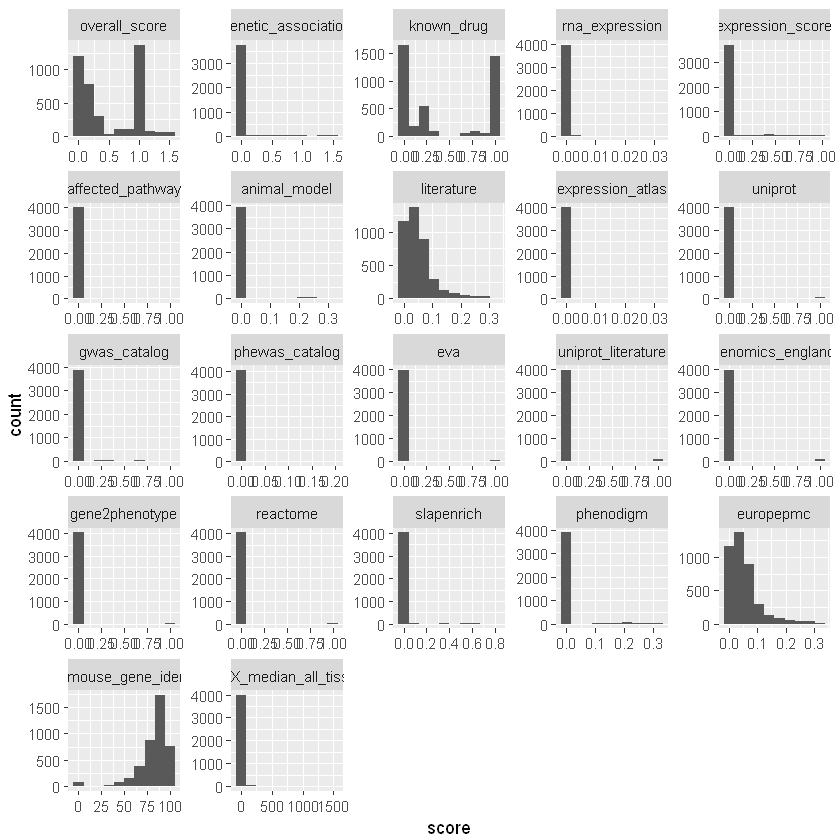

In [149]:
g = ggplot(all.long, aes(score)) +
  geom_histogram(bins = 10) + 
  facet_wrap(~datasource, scales = "free")
print(g)

`geom_smooth()` using method = 'gam'
Warning message:
"Computation failed in `stat_smooth()`:
x has insufficient unique values to support 10 knots: reduce k."Warning message:
"Computation failed in `stat_smooth()`:
x has insufficient unique values to support 10 knots: reduce k."Warning message:
"Computation failed in `stat_smooth()`:
x has insufficient unique values to support 10 knots: reduce k."Warning message:
"Computation failed in `stat_smooth()`:
x has insufficient unique values to support 10 knots: reduce k."Warning message:
"Computation failed in `stat_smooth()`:
x has insufficient unique values to support 10 knots: reduce k."

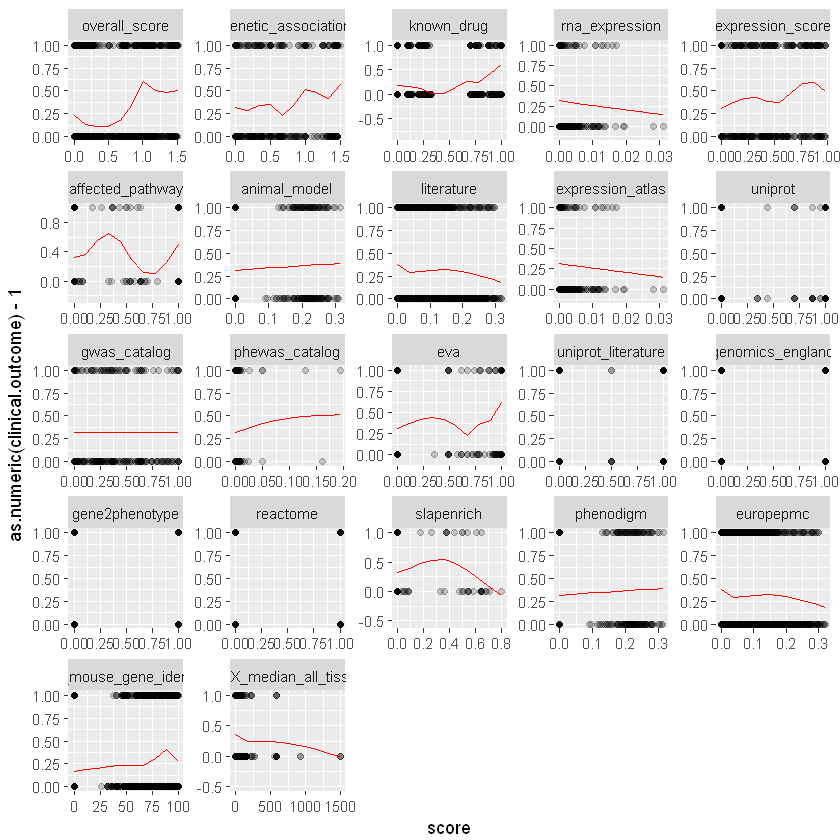

In [150]:
g = ggplot(all.long, aes(score, as.numeric(clinical.outcome) - 1)) +
    geom_point(alpha = 0.2) +  
    stat_smooth(geom = "line", n = 10, color = "red") + 
    facet_wrap(~datasource, scales = "free")
print(g)

### Converting scores into binary measures of positive and negative evidence

Looking at the relationship between the various Open Targets scores and T-I success, it appears that score values below 0.25 are generally associated with lower success rates, though this varies for many score types.  Let's set a threshold value of 0.1 and call everything that exceeds that as having positive evidence.

In [151]:
pos.score.vars = paste(c(ot.scores, otsrc.scores), ".pos", sep = "")
names(pos.score.vars) = c(ot.scores, otsrc.scores)
for(i in names(pos.score.vars)) {
    all.data[, pos.score.vars[i]] = cut(all.data[, i], c(0, 0.1, 100), 
                                        labels = c("Negative", "Positive"),
                                        include.lowest = TRUE)
}
do.call("rbind", apply(all.data[, pos.score.vars], 2, table))

,Negative,Positive
overall_score.pos,1328,2736
genetic_association.pos,3762,302
known_drug.pos,1768,2296
rna_expression.pos,4064,4064
expression_score.pos,3707,357
affected_pathway.pos,4003,61
animal_model.pos,3895,169
literature.pos,3543,521
expression_atlas.pos,4064,4064
uniprot.pos,3982,82


In [152]:
or.mat = matrix(NA, ncol = 3, nrow = length(pos.score.vars), 
               dimnames = list(pos.score.vars, 
                               c("OR", "Lower", "Upper")))
or.list = list()
for(i in pos.score.vars) {
    or.list[[i]][["Table"]] = table(all.data[, "clinical.outcome"], 
                                    all.data[, i])
    or.list[[i]][["Test"]] = fisher.test(or.list[[i]][["Table"]])
    or.mat[i,] = unlist(or.list[[i]][["Test"]][c("estimate", "conf.int")])
}
or.mat

,OR,Lower,Upper
overall_score.pos,3.4077847,2.8823575,4.041107
genetic_association.pos,1.3713346,1.0667681,1.757202
known_drug.pos,3.7213146,3.1993641,4.335960
rna_expression.pos,0.0000000,0.0000000,Inf
expression_score.pos,1.9182899,1.5296043,2.403548
affected_pathway.pos,1.6058173,0.9239383,2.758392
animal_model.pos,1.3948836,1.0004791,1.933610
literature.pos,0.9537654,0.7766443,1.167726
expression_atlas.pos,0.0000000,0.0000000,Inf
uniprot.pos,1.7862454,1.1180972,2.838363


Repeat categorization for human-mouse protein sequence identity and GTEx median tissue (not currently in Open Targets).


In [153]:
pos.gene.qvars = paste(gene.qvars, ".pos", sep = "")
all.data = all.data %>%
    mutate(pc_mouse_gene_identity.pos = 
           ifelse(pc_mouse_gene_identity > 70, "Positive", "Negative")) %>%
    mutate(GTEX_median_all_tissues.pos = 
           ifelse(GTEX_median_all_tissues < 0.5, "Positive", "Negative"))
apply(all.data[, pos.gene.qvars], 2, table)

,pc_mouse_gene_identity.pos,GTEX_median_all_tissues.pos
Negative,597,2328
Positive,3467,1736


In [154]:
or.mat = matrix(NA, ncol = 3, nrow = length(pos.gene.qvars), 
               dimnames = list(pos.gene.qvars, c("OR", "Lower", "Upper")))
or.list = list()
for(i in pos.gene.qvars) {
    or.list[[i]][["Table"]] = table(all.data[, "clinical.outcome"], 
                                    all.data[, i])
    or.list[[i]][["Test"]] = fisher.test(or.list[[i]][["Table"]])
    or.mat[i,] = unlist(or.list[[i]][["Test"]][c("estimate", "conf.int")])
}
or.mat

,OR,Lower,Upper
pc_mouse_gene_identity.pos,1.713860,1.392942,2.118962
GTEX_median_all_tissues.pos,1.289462,1.126355,1.476164


### Categorical gene features


In [155]:
summary((all.data[, gene.cvars]))

            protein_class                target_class     topology_type 
 Secreted protein  : 239   7TM_Group1          : 998   Membrane  : 358  
 Oxidoreductase    : 229   Enzyme_all_others   : 545   MultiTM   :1751  
 Membrane receptor : 220   Receptor_all_others : 444   Secreted  : 593  
 Enzyme            : 188   Ion Channel         : 385   SingleTM  : 612  
 Serotonin receptor: 147   Extracellular Ligand: 306   Unattached: 750  
 (Other)           :2753   Kinase_Protein      : 247                    
 NA's              : 288   (Other)             :1139                    
      target_location              ExAC_LoF   
 Cytoplasm    : 210   Intolerant to LoF:1175  
 Exposed      :2186   Missing          :  96  
 Free         : 593   Tolerant to LoF  : 702  
 Mitochondrion: 152   Unclassified     :2091  
 Nucleus      : 432                           
 Organelle    : 491                           
 Unknown      :   0                           

In [156]:
protein.classes = table(all.data$protein_class)
common.protein.classes = names(protein.classes[protein.classes >= 50])
all.data$pcred = as.character(all.data$protein_class)
all.data$pcred[!(all.data$pcred %in% common.protein.classes)] = "Other"
g = glm(clinical.outcome ~ pcred, all.data, family = binomial(link = "logit"))
summary(g)
anova(g, test = "Chisq")


Call:
glm(formula = clinical.outcome ~ pcred, family = binomial(link = "logit"), 
    data = all.data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.6651  -0.6923  -0.6923   1.1149   2.7971  

Coefficients:
                                                           Estimate Std. Error
(Intercept)                                                  0.8842     0.2727
pcredAdrenergic receptor                                    -0.4268     0.3272
pcredCC chemokine receptor                                  -4.7760     1.0463
pcredDopamine receptor                                      -1.1355     0.3416
pcredEnzyme                                                 -2.7591     0.3471
pcredGABA-A receptor                                        -0.7431     0.3619
pcredHistamine receptor                                     -1.0993     0.3829
pcredHydrolase                                              -0.8465     0.3871
pcredMembrane receptor                                  

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
NULL,NA,NA,4063,5082.330,NA
pcred,19,473.3949,4044,4608.935,2.105904e-88


In [157]:
g = glm(clinical.outcome ~ target_class, all.data, 
        family = binomial(link = "logit"))
summary(g)
anova(g, test = "Chisq")


Call:
glm(formula = clinical.outcome ~ target_class, family = binomial(link = "logit"), 
    data = all.data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.1486  -0.9563  -0.7664   1.4068   2.0867  

Coefficients:
                                              Estimate Std. Error z value
(Intercept)                                    -1.3106     0.2300  -5.698
target_class7TM_Group1                          0.7858     0.2392   3.286
target_classEnzyme_all_others                   0.7654     0.2466   3.104
target_classEnzyme_Esterase                     0.3649     0.2871   1.271
target_classEnzyme_Transferase                  0.1066     0.5192   0.205
target_classExtracellular Ligand               -0.1424     0.2724  -0.523
target_classExtracellular_all_others           -0.1935     0.3744  -0.517
target_classIon Channel                         0.7284     0.2534   2.875
target_classKinase_Protein                     -0.7463     0.3053  -2.445
target_classNuclear 

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
NULL,NA,NA,4063,5082.330,NA
target_class,14,175.033,4049,4907.297,6.572631e-30


In [158]:
g = glm(clinical.outcome ~ topology_type, all.data, 
        family = binomial(link = "logit"))
summary(g)
anova(g, test = "Chisq")


Call:
glm(formula = clinical.outcome ~ topology_type, family = binomial(link = "logit"), 
    data = all.data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.0467  -0.9520  -0.7557   1.4210   1.6699  

Coefficients:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)              -0.3154     0.1070  -2.947   0.0032 ** 
topology_typeMultiTM     -0.2410     0.1180  -2.043   0.0410 *  
topology_typeSecreted    -0.6377     0.1409  -4.526 6.00e-06 ***
topology_typeSingleTM    -0.7919     0.1421  -5.571 2.53e-08 ***
topology_typeUnattached  -0.7939     0.1364  -5.820 5.87e-09 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 5082.3  on 4063  degrees of freedom
Residual deviance: 5012.0  on 4059  degrees of freedom
AIC: 5022

Number of Fisher Scoring iterations: 4


,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
NULL,NA,NA,4063,5082.330,NA
topology_type,4,70.36218,4059,5011.967,1.903393e-14


In [159]:
g = glm(clinical.outcome ~ target_location, all.data, 
        family = binomial(link = "logit"))
summary(g)
anova(g, test = "Chisq")


Call:
glm(formula = clinical.outcome ~ target_location, family = binomial(link = "logit"), 
    data = all.data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.0782  -0.8878  -0.8075   1.4978   1.7427  

Coefficients:
                             Estimate Std. Error z value Pr(>|z|)    
(Intercept)                   -1.2712     0.1668  -7.619 2.55e-14 ***
target_locationExposed         0.5436     0.1730   3.143  0.00168 ** 
target_locationFree            0.3180     0.1904   1.671  0.09475 .  
target_locationMitochondrion   1.0333     0.2335   4.425 9.65e-06 ***
target_locationNucleus         0.1226     0.2012   0.609  0.54239    
target_locationOrganelle       0.8793     0.1905   4.615 3.93e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 5082.3  on 4063  degrees of freedom
Residual deviance: 5028.8  on 4058  degrees of freedom
AIC: 5040.8

Number of Fisher S

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
NULL,NA,NA,4063,5082.330,NA
target_location,5,53.48264,4058,5028.847,2.677045e-10


In [160]:
g = glm(clinical.outcome ~ ExAC_LoF, all.data, 
        family = binomial(link = "logit"))
summary(g)
anova(g, test = "Chisq")


Call:
glm(formula = clinical.outcome ~ ExAC_LoF, family = binomial(link = "logit"), 
    data = all.data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.0383  -0.8965  -0.8854   1.4871   1.6532  

Coefficients:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)             -0.73428    0.06232 -11.782  < 2e-16 ***
ExAC_LoFMissing          0.39781    0.21620   1.840  0.06576 .  
ExAC_LoFTolerant to LoF -0.33791    0.10669  -3.167  0.00154 ** 
ExAC_LoFUnclassified     0.03036    0.07774   0.390  0.69618    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 5082.3  on 4063  degrees of freedom
Residual deviance: 5063.0  on 4060  degrees of freedom
AIC: 5071

Number of Fisher Scoring iterations: 4


,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
NULL,NA,NA,4063,5082.330,NA
ExAC_LoF,3,19.30799,4060,5063.022,0.0002360979


## Save the main analysis dataset as an RData file

In [161]:
save(all.data, file = "datathon_OTdata.RData", compress = TRUE)

## Example prediction model
### Backwards stepwise regression


In [162]:
set.seed(6475250)
train.select = sample(1:nrow(all.data), size = nrow(all.data) * 0.8, 
                      replace = FALSE)
train.data = all.data[train.select,]
test.data = subset(all.data, !(key %in% train.data$key))

In [163]:
indep.vars = c(pos.score.vars, pos.gene.qvars,
               "pcred", "target_class", "topology_type", 
               "target_location", "ExAC_LoF")
## Eliminate those that are too rare to be robust and the known drug (chembl) information (cheating)
indep.vars = indep.vars[!(indep.vars %in% 
                          c("overall_score.pos", "known_drug.pos", "affected_pathway.pos",
                           "uniprot.pos", "eva.pos", "rna_expression.pos", "expression_atlas.pos",
                           "phewas_catalog.pos"))]
full.glm = glm(clinical.outcome ~ ., train.data[, c("clinical.outcome", indep.vars)],
              family = binomial)
anova(full.glm, test = "Chisq")

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
NULL,NA,NA,3250,4058.658,NA
genetic_association.pos,1,2.787913e+00,3249,4055.870,9.497785e-02
expression_score.pos,1,2.587386e+01,3248,4029.997,3.644709e-07
animal_model.pos,1,4.634689e-01,3247,4029.533,4.960072e-01
literature.pos,1,1.212461e+00,3246,4028.321,2.708452e-01
gwas_catalog.pos,1,9.557707e+00,3245,4018.763,1.991116e-03
uniprot_literature.pos,1,2.892674e-03,3244,4018.760,9.571076e-01
genomics_england.pos,1,1.417754e+00,3243,4017.342,2.337734e-01
gene2phenotype.pos,1,3.976117e-01,3242,4016.945,5.283253e-01
reactome.pos,1,9.262695e-01,3241,4016.018,3.358342e-01


In [164]:
back.glm = step(full.glm, trace = 0)
anova(back.glm, test = "Chisq")

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
NULL,NA,NA,3250,4058.658,NA
genetic_association.pos,1,2.787913,3249,4055.870,9.497785e-02
expression_score.pos,1,25.873863,3248,4029.997,3.644709e-07
gwas_catalog.pos,1,9.697834,3247,4020.299,1.844853e-03
pcred,19,372.635128,3228,3647.664,2.108716e-67
target_class,14,63.213543,3214,3584.450,3.180536e-08
topology_type,4,26.850235,3210,3557.600,2.131400e-05


For comparison, here's the result of the forward stepwise selection.  It does not retain any of the Target-indication information.

In [165]:
null.glm = glm(clinical.outcome ~ 1, train.data, family = binomial)
forward.glm = step(null.glm, 
                scope = list(lower = formula(null.glm),
                            upper = formula(full.glm)),
                direction = "forward", trace = 0)
anova(forward.glm, test = "Chisq")

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
NULL,NA,NA,3250,4058.658,NA
pcred,19,362.08369,3231,3696.575,3.234423e-65
target_class,14,71.65409,3217,3624.921,9.667941e-10
topology_type,4,28.08843,3213,3596.832,1.196862e-05
expression_score.pos,1,18.59139,3212,3578.241,1.619507e-05
genomics_england.pos,1,15.26273,3211,3562.978,9.354418e-05


Let's take a look at the estimates of the probabilities of success for the failed and successful target-indication pairs for the training and testing data sets.

In [166]:
test.data$pred.prob = predict(back.glm, newdata = test.data, 
                            type = "response")
train.data$pred.prob = predict(back.glm, newdata = train.data, 
                              type = "response")

In [167]:
by(train.data[, "pred.prob"], list(train.data$clinical.outcome), summary)

: Failure
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.01055 0.14633 0.22336 0.26958 0.36068 0.79590 
------------------------------------------------------------ 
: Success
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.05106 0.23989 0.41994 0.41788 0.57511 0.80216 

In [168]:
by(test.data[, "pred.prob"], list(test.data$clinical.outcome), summary)

: Failure
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.01055 0.15404 0.22444 0.27318 0.36068 0.80888 
------------------------------------------------------------ 
: Success
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.06506 0.28071 0.43494 0.43507 0.58749 0.85248 

There are several indications approved for many of the targets (drugs).  Let's check how these compare when we limit the results just to the first approved indication for a given target.

In [169]:
lVec = test.data$Indication.with.First.Clinical.Outcome.for.Target %in% "Y"
by(test.data[lVec, "pred.prob"], list(test.data$clinical.outcome[lVec]), summary)

: Failure
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.01055 0.14633 0.22336 0.23923 0.25208 0.76777 
------------------------------------------------------------ 
: Success
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.1371  0.2741  0.4431  0.4420  0.5885  0.7786 

In [170]:
train.data = train.data %>%
    mutate(pred.outcome = ifelse(pred.prob >= 0.5, "Success", "Failure"))
test.data = test.data %>%
    mutate(pred.outcome = ifelse(pred.prob >= 0.5, "Success", "Failure"))

Confusion matrices if we set a threshold of 0.5 to categorize the results as a success.

In [171]:
cat("train.data\n")
xtabs(~ clinical.outcome + pred.outcome, train.data)
cat("test.data\n")
xtabs(~ clinical.outcome + pred.outcome, test.data)

train.data


                pred.outcome
clinical.outcome Failure Success
         Failure    1992     230
         Success     671     358

test.data


                pred.outcome
clinical.outcome Failure Success
         Failure     497      53
         Success     159     104

auc.train  auc.test 
    0.733     0.755

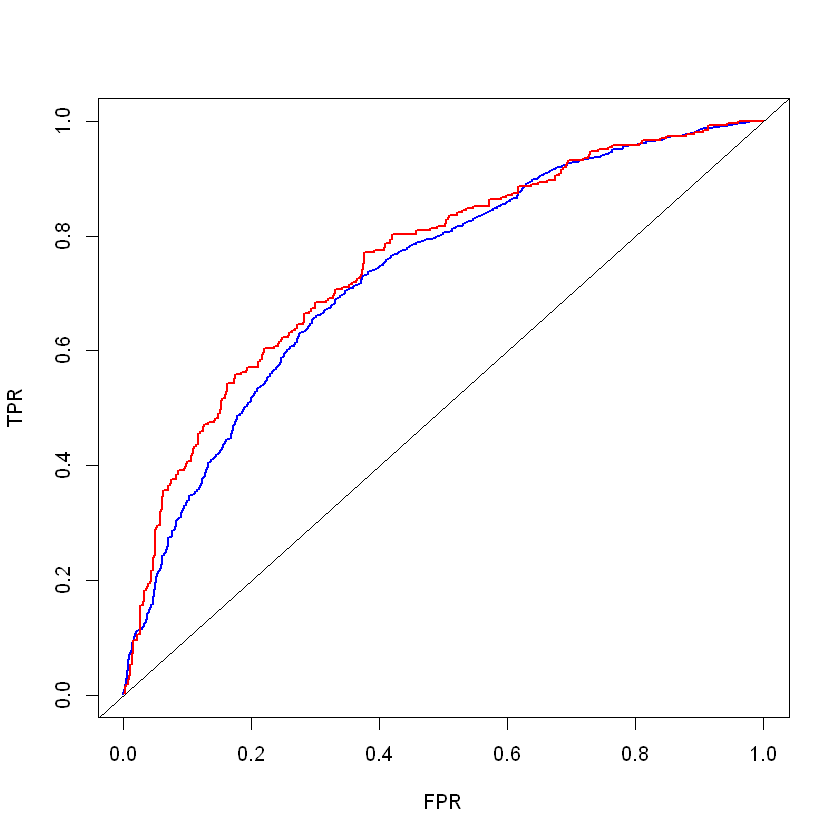

In [172]:
## I just stole this code from Revolutions at
## http://blog.revolutionanalytics.com/2016/11/calculating-auc.html
simple_roc <- function(labels, scores){
  labels <- labels[order(scores, decreasing=TRUE)]
  data.frame(TPR=cumsum(labels)/sum(labels), FPR=cumsum(!labels)/sum(!labels), labels)
}

simple_auc <- function(TPR, FPR){
  # inputs already sorted, best scores first 
  dFPR <- c(diff(FPR), 0)
  dTPR <- c(diff(TPR), 0)
  sum(TPR * dFPR) + sum(dTPR * dFPR)/2
}

roc.train = simple_roc(train.data$clinical.outcome %in% "Success",
                      train.data$pred.prob)
roc.test = simple_roc(test.data$clinical.outcome %in% "Success",
                      test.data$pred.prob)
plot(TPR ~ 1 - FPR, roc.train, type = "l", lwd = 2, col = "blue")
lines(TPR ~ 1 - FPR, roc.test, lwd = 2, col = "red")
abline(0, 1)

auc.train = simple_auc(roc.train$TPR, roc.train$FPR)
auc.test = simple_auc(roc.test$TPR, roc.test$FPR)
round(c(auc.train = auc.train, auc.test = auc.test), 3)

## Some cautionary notes
While the strategy of using the historical drug development record to fit models of target--indication success has many advantages, we also need to be aware of limitations in the data.  For example:
* Less than 5% of protein--coding genes have ever been explored in the clinic
* The proteins that have been explored in the clinic represent a very biased subset of the coding genes as a whole

In [173]:
n_distinct(all.data$entrez_id)
all.data  %>% 
    group_by(clinical.outcome) %>% 
    summarise(unique = n_distinct(entrez_id))

[1] 798

clinical.outcome,unique
Failure,744
Success,329


* A modest number of diseases have been explored, and for a highly biased subset of corresponding targets

In [174]:
n_distinct(all.data$MeSH_ID)
all.data  %>% 
    group_by(clinical.outcome) %>% 
    summarise(unique = n_distinct(MeSH_ID))

[1] 403

clinical.outcome,unique
Failure,312
Success,298


* Some indications have been pursued by a lot of targets

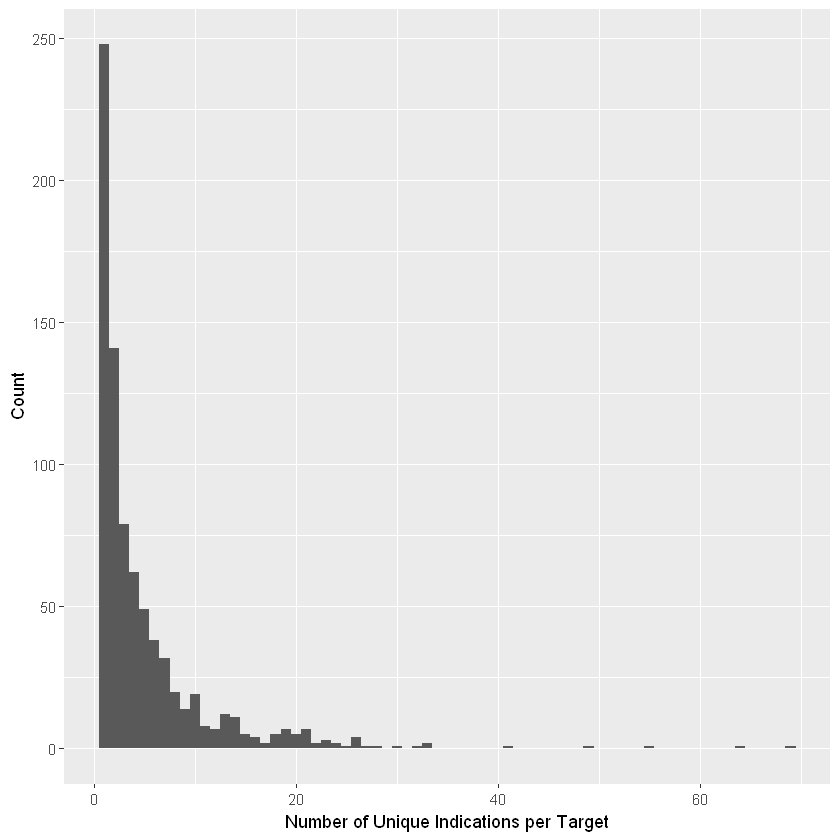

In [175]:
x <- table(as.character(all.data$entrez_id))
g <- ggplot(data.frame(Ind = x), aes(Ind.Freq)) + geom_histogram(binwidth = 1) +
    labs(x = "Number of Unique Indications per Target", y = "Count")
print(g)

* Some targets have been studied for lots of indications

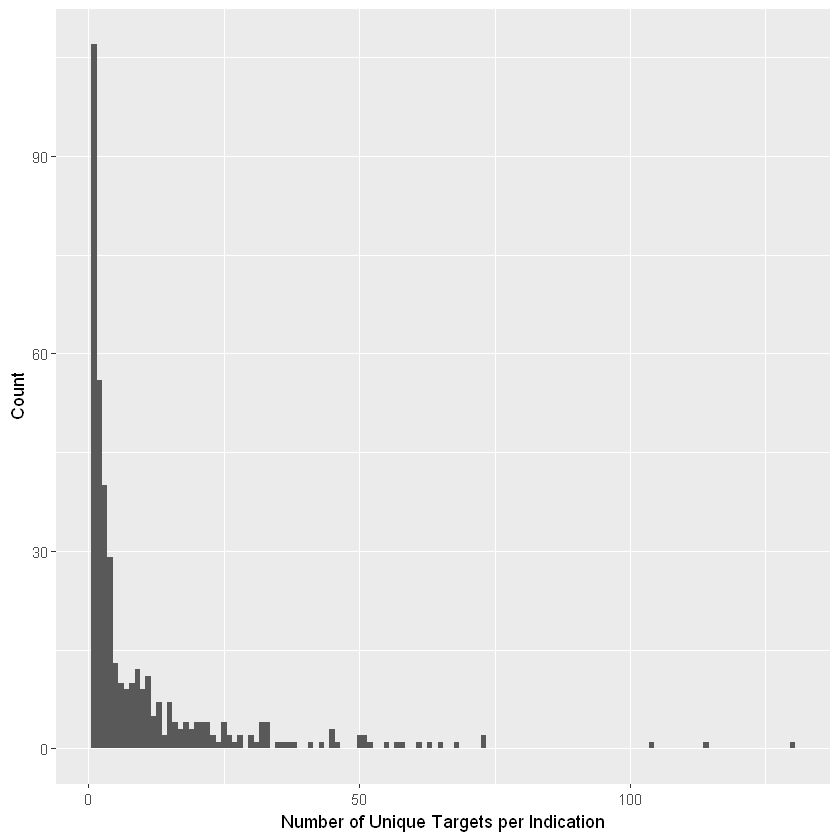

In [176]:
x <- table(as.character(all.data$MeSH_ID))
g <- ggplot(data.frame(Ind = x), aes(Ind.Freq)) + geom_histogram(binwidth = 1) +
    labs(x = "Number of Unique Targets per Indication", y = "Count")
print(g)

* Targets that have been tried for a larger number of indications show a higher proportion of success, with a strong preference for indication adjacencies.  These could be considered as duplicates of one another

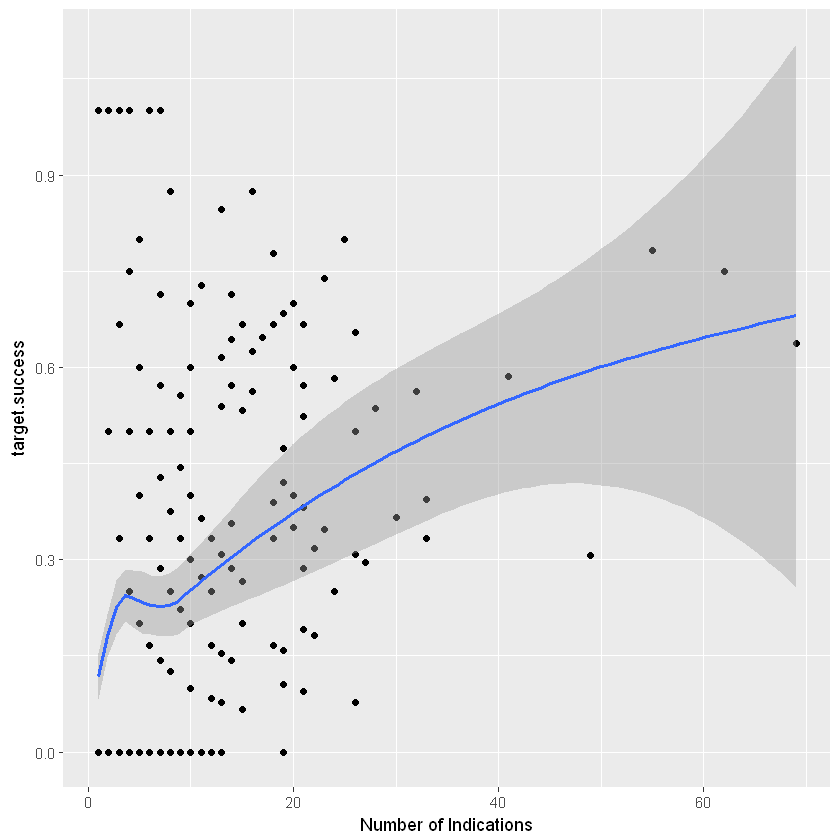

In [177]:
success.fxn = function(x) { sum(x %in% "Success")/length(x) }
target.success = all.data %>% 
    group_by(entrez_id) %>%
    summarise(ind.count = n_distinct(MeSH_ID), 
              target.success = success.fxn(clinical.outcome))
g <- ggplot(target.success, aes(ind.count, target.success)) + geom_point() +
    geom_smooth(method = "loess") + xlab("Number of Indications")
print(g)

## Repeating simple logistic model without duplicate targets

We can assess the robustness of our prediction model by repeating the logistic regression model selection on a subset of the data that retains only a single, randomly selected indication for each target.

In [178]:
## Create subset of all.data, randomly selecting one indication per target
u.all.data = subset(all.data[sample(1:nrow(all.data)),],
                   !duplicated(entrez_id))
## Randomly select training and test set
u.all.data$Train = sample(c(TRUE, FALSE), size = nrow(u.all.data), 
                          replace = TRUE, prob = c(0.8, 0.2))
summary(u.all.data[, c("clinical.outcome", "entrez_id", "MeSH_ID", "Train")])

 clinical.outcome   entrez_id            MeSH_ID      Train        
 Failure:651      Min.   :        2   D001172: 33   Mode :logical  
 Success:147      1st Qu.:     1820   D009190: 31   FALSE:148      
                  Median :     3716   D011565: 27   TRUE :650      
                  Mean   :   136739   D001249: 21                  
                  3rd Qu.:     6366   D003924: 18                  
                  Max.   :100133941   D000544: 17                  
                                      (Other):651                  

In [179]:
u.train.data = subset(u.all.data, Train)
u.test.data = subset(u.all.data, !Train)
u.indep.vars = indep.vars[!(indep.vars %in% "phenodigm.pos")]

u.full.glm = glm(clinical.outcome ~ ., 
                u.train.data[, c("clinical.outcome", u.indep.vars)],
              family = binomial)
u.backward.glm = step(u.full.glm, trace = 0)
anova(u.backward.glm, test = "Chisq")

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
NULL,NA,NA,649,612.8115,NA
expression_score.pos,1,7.801133,648,605.0104,5.221349e-03
uniprot_literature.pos,1,15.874205,647,589.1362,6.769512e-05
reactome.pos,1,5.045345,646,584.0908,2.469219e-02
pc_mouse_gene_identity.pos,1,3.796741,645,580.2941,5.135244e-02
pcred,19,59.663736,626,520.6304,4.373491e-06
target_location,5,25.435363,621,495.1950,1.147920e-04


In [180]:
u.test.data$pred.prob = predict(u.backward.glm, newdata = u.test.data, 
                            type = "response")
u.train.data$pred.prob = predict(u.backward.glm, newdata = u.train.data, 
                              type = "response")

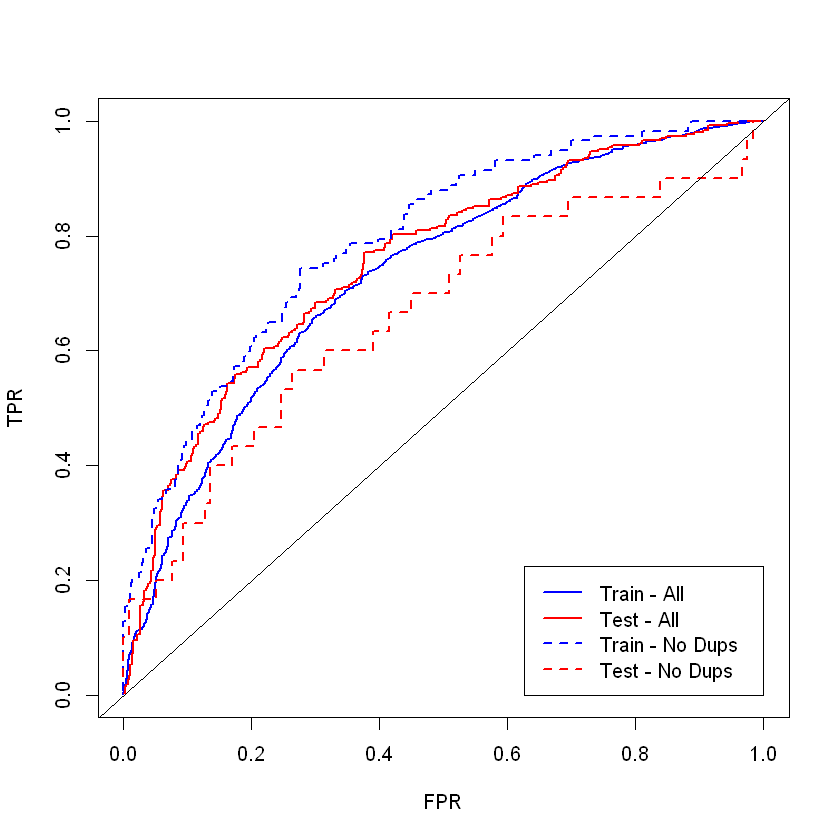

In [181]:
u.roc.train = simple_roc(u.train.data$clinical.outcome %in% "Success",
                      u.train.data$pred.prob)
u.roc.test = simple_roc(u.test.data$clinical.outcome %in% "Success",
                      u.test.data$pred.prob)
plot(TPR ~ 1 - FPR, roc.train, type = "l", lwd = 2, col = "blue")
lines(TPR ~ 1 - FPR, roc.test, lwd = 2, col = "red")
lines(TPR ~ 1 - FPR, u.roc.train, lwd = 2, col = "blue", lty = 2)
lines(TPR ~ 1 - FPR, u.roc.test, lwd = 2, col = "red", lty = 2)
abline(0, 1)
legend(1, 0, c("Train - All", "Test - All", "Train - No Dups", "Test - No Dups"), 
       lty = c(1, 1, 2, 2), lwd = 2, col = rep(c("blue", "red"), 2), xjust = 1, yjust = 0)

## Assessment of first indication versus random indications for targets

In [182]:
x = xtabs(~ Indication.with.First.Clinical.Outcome.for.Target + clinical.outcome, all.data)
print(x)

                                                 clinical.outcome
Indication.with.First.Clinical.Outcome.for.Target Failure Success
                                                N    2424    1118
                                                Y     348     174


In [183]:
fisher.test(x)


	Fisher's Exact Test for Count Data

data:  x
p-value = 0.4208
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.8862145 1.3227013
sample estimates:
odds ratio 
  1.084055 


In [184]:
all.data$Train = all.data$key %in% train.data$key
x2 = xtabs(~ Train + clinical.outcome, all.data)
print(x2)

       clinical.outcome
Train   Failure Success
  FALSE     550     263
  TRUE     2222    1029


In [185]:
fisher.test(x2)


	Fisher's Exact Test for Count Data

data:  x2
p-value = 0.7049
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.8193584 1.1464610
sample estimates:
odds ratio 
 0.9684309 
